# Spectral Bounds for the Operator Pencil of an Elliptic System in an Angle

This notebook numerically implements parts of the paper [Spectral Bounds for the Operator Pencil of an Elliptic System in an Angle](https://arxiv.org/abs/2412.11858).


#### Key Features:
1. Checking ellipticity of a tuple.
2. Calculating the monic reduction of an elliptic touple.
3. Computing the standard root of an elliptic tuple and verifying algebraic relations.
4. Plots for the relationship between the regularity parameter $\lambda$ and the opening angle $\alpha$.

#### Library Versions Used (Last Updated):
- **Numpy**: 2.2.6
- **Matplotlib**: 3.10.3
- **SciPy**: 1.15.3

This notebook was developed with assistance from OpenAI's ChatGPT (version: GPT-4, December 2024).

In [20]:
# ===============================
# 1. Setup
# ===============================

# Import standard libraries
from math import pi
from cmath import exp, cos, sin, log  # Complex math utilities

# Import third-party libraries
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Plotting utilities
from scipy.linalg import eig, inv, det  # Linear algebra functions

# Log versions of important libraries for reproducibility
import importlib.metadata
print(f"Numpy version: {importlib.metadata.version('numpy')}")
print(f"Matplotlib version: {importlib.metadata.version('matplotlib')}")
print(f"SciPy version: {importlib.metadata.version('scipy')}")

Numpy version: 2.2.6
Matplotlib version: 3.10.3
SciPy version: 1.15.3


## 1. Calculating the monic reduction of an elliptic touple
The monic reduction of a given tuple is calculated. For more details, refer to Section 3.1 of the paper.

Let us consider the following elliptic tuple:

In [21]:
# Define matrices for the tuple
A_11 = np.array([[3, -0.3], [-0.3, 1.5]])
A_12 = np.array([[1.5, -0.9], [-0.9, 0.8]])
A_22 = np.array([[2.5, 0.3], [0.3, 1.8]])

The monic reduction is calculated by using $A_{22}^{1/2}$:

In [22]:
def compute_monic_reduction(A_11, A_12, A_22):
    """Compute the monic reduction of the tuple (A_11, A_12, A_22)."""

    # Compute A_22^{-1/2}
    eigvals, eigvecs = np.linalg.eigh(A_22)  # Symmetric eigenvalue decomposition
    A_22_inv_sqrt = eigvecs @ np.diag(1 / np.sqrt(eigvals)) @ eigvecs.T  # A_22^{-1/2}
    
    # Compute monic reduction
    A_tilde_11 = A_22_inv_sqrt @ A_11 @ A_22_inv_sqrt
    A_tilde_12 = A_22_inv_sqrt @ A_12 @ A_22_inv_sqrt
    Identity = np.eye(A_22.shape[0])  # Identity matrix of size matching A_22
    
    return A_tilde_11, A_tilde_12, Identity

A_11, A_12, A_22 = compute_monic_reduction(A_11, A_12, A_22)
print(f"The monic reduction is given by:\n")
print(f"A_11 =\n{A_11}\n")
print(f"A_12 =\n{A_12}\n")
print(f"A_22 =\n{A_22}\n")

The monic reduction is given by:

A_11 =
[[ 1.23961585 -0.29315726]
 [-0.29315726  0.87603041]]

A_12 =
[[ 0.6667467  -0.50916367]
 [-0.50916367  0.52146192]]

A_22 =
[[1. 0.]
 [0. 1.]]



## 2. Computing the standard root

The standard root $V$ is calculated (see Lemma 3.2) using the eigenvalues and eigenvectors of the so-called quadratic eigenvalue problem. The quadratic eigenvalue equation is transformed into a linear problem following the approach in **Section 3.4** of [The Quadratic Eigenvalue Problem](https://www.jstor.org/stable/3649752). This might not work, if the algebraic and geometric multiplicities of the linear eigenvalue problem do not coincide.

Key steps:
- Solve the quadratic eigenvalue equation using linearization.
- Extract eigenvalues with positive imaginary parts.
- Use the eigenvalues and eigenvectors to define the standard root $V$.

The resulting matrix is computed as $ V=Q B Q^{-1} $, where $ Q $ contains the eigenvectors and $ B $ is the diagonal matrix of selected eigenvalues.

We use the monic elliptic tuple from _1. Calculating the monic reduction of an elliptic touple_ which are stored in $A_{11},A_{12},A_{22}$.

In [23]:
import numpy as np
from scipy.linalg import eig, inv

def quadr(A, B, C):
    """
    Compute the eigenvalues and eigenvectors of the quadratic eigenvalue problem
    using a linearization approach.
    
    Args:
        A, B, C (np.ndarray): Coefficients of the quadratic eigenvalue equation.
        
    Returns:
        tuple: Eigenvalues and eigenvectors of the linearized system.
    """
    n = A.shape[0]
    X = np.block([[np.zeros((n, n)), np.eye(n)], [-A, -B]])
    Y = np.block([[np.eye(n), np.zeros((n, n))], [np.zeros((n, n)), C]])
    return eig(X, Y)

def getV(A_11, A_12):
    """
    Extract eigenvalues with positive imaginary parts and their corresponding eigenvectors
    from the quadratic eigenvalue equation.
    """ 
    # Solve the quadratic eigenvalue problem
    n = A_11.shape[0]
    eigenvalues, eigenvectors = quadr(A_11, 2 * A_12, np.eye(n))
    
    # Select eigenvalues with positive imaginary parts
    positive_imag_indices = np.where(eigenvalues.imag > 0)[0]
    if positive_imag_indices.size == 0:
        raise ValueError("No eigenvalues with positive imaginary parts found.")
    
    # Extract eigenvectors and construct diagonal matrix B
    Q = eigenvectors[:n, positive_imag_indices]
    B = np.diag(eigenvalues[positive_imag_indices])
    
    # Compute Q @ B @ inv(Q)
    try:
        result = Q @ B @ inv(Q)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix inversion failed. Eigenvector matrix Q might be ill-conditioned.")
    
    return result

# Calculate V
try:
    V = getV(A_11, A_12)
    print("The standard root of the tuple is:\n", np.round(V, decimals=4))
except ValueError as e:
    print("Error:", e)

The standard root of the tuple is:
 [[-0.6667+0.6437j  0.4534+0.2481j]
 [ 0.5649+0.2481j -0.5215+0.5805j]]


## 4. Plots for the relationship between the regularity parameter $\lambda$ and the opening angle $\alpha$.


In this part, we analyze the relationship between the opening angle $ \alpha $ and the regularity parameter $ \lambda $ for the model problem. The analysis relies on Section 5 of the paper. Note that $0\in \sigma(A)\iff \det(A)=0$.

### 4.1 Implementing complex exponentiation and $\det( M_{\lambda,\alpha})$

1. Implement complex exponentiation that accounts for different branches of the logarithm.
2. Implement $\det( M_{\lambda,\alpha}) $ for Dirichlet, mixed, and Neumann boundary conditions.

In [24]:
import numpy as np
from scipy.linalg import eig, inv, det
from cmath import log, exp, cos, sin

def complex_log(z, branch=0):
    """
    Compute the logarithm of a complex number with branch control.
    
    Args:
        z (complex): Input complex number.
        branch (int): Logarithm branch (-1, 0, or 1).
    """
    z_abs = np.abs(z)
    z_arg = np.angle(z)

    if branch == 1 and z_arg < 0:
        z_arg += 2 * np.pi
    elif branch == -1 and z_arg > 0:
        z_arg -= 2 * np.pi
    elif branch not in (-1, 0, 1):
        raise ValueError(f"Invalid branch value: {branch}")

    return log(z_abs) + 1j * z_arg

def complex_exponent(z, lamb, branch=0):
    """
    Compute z^lamb using a logarithmic branch control.
    """
    return exp(lamb * complex_log(z, branch))

def matrix_function(M, func):
    """
    Implementing functional calculus
    """
    B, Q = eig(M)  # Eigenvalues and eigenvectors
    return Q @ np.diag([func(b) for b in B]) @ inv(Q)

def det_dirichlet(S, D, lamb, alpha):
    """
    Compute det(M_lambda,alpha) for Dirichlet boundary conditions.
    """
    V = S@D+1j*D
    Va = np.eye(V.shape[0]) * cos(alpha) + sin(alpha) * V
    Val = matrix_function(Va, lambda z: complex_exponent(z, lamb, branch=1))
    Val_c = matrix_function(np.conj(Va), lambda z: complex_exponent(z, lamb, branch=-1))
    return det(Val - Val_c)

def det_mixed(S, D, lamb, alpha):
    """
    Compute det(M_lambda,alpha) for Mixed boundary conditions.
    """
    V = S@D+1j*D
    Va = np.eye(V.shape[0]) * cos(alpha) + sin(alpha) * V
    Val = matrix_function(Va, lambda z: complex_exponent(z, lamb, branch=1))
    Val_c = matrix_function(np.conj(Va), lambda z: complex_exponent(z, lamb, branch=-1))
    E = 0.5 * (S @ D - D @ S) + 1j * D
    return det(E @ Val - np.conj(E) @ Val_c)

def det_neumann(S, D, lamb, alpha):
    """
    Compute det(M_lambda,alpha) for Neumann boundary conditions.
    """
    V = S@D+1j*D
    Va = np.eye(V.shape[0]) * cos(alpha) + sin(alpha) * V
    Val = matrix_function(Va, lambda z: complex_exponent(z, lamb, branch=1))
    Val_c = matrix_function(np.conj(Va), lambda z: complex_exponent(z, lamb, branch=-1))
    E = 0.5 * (S @ D - D @ S) + 1j * D
    return det(E @ Val @ inv(E) - np.conj(E) @ Val_c @ inv(np.conj(E)))

### 4.2 Implementing a solver starting from $\alpha=2\pi$

Using Newton's method, we implement a solver which calculates different branches of pairs $(\alpha,\lambda)$ such that $ \det(M_{\lambda,\alpha})=0 $:
1. Starting from an initial guess $\lambda_0 $ at $\alpha=2\pi$, we compute solutions iteratively for a sequence of $ \alpha $ values.
2. Each solution serves as the initial guess for the next iteration. Using small perturbation, we are able to detect different branches. 


In [25]:
def newton_complex(f, x0, tol=1e-5, maxiter=100):
    """
    Perform Newton's method for finding roots of a complex function.
    """
    def fprime(z):
        h = 1e-10
        return (f(z + h) - f(z - h)) / (2 * h)  # Central difference for better accuracy

    x = x0
    for i in range(maxiter):
        fx = f(x)
        fpx = fprime(x)
        if abs(fpx) < tol:  # Warn if the derivative is too small
            raise ZeroDivisionError(f"Derivative is too small near z = {x}.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:  # Convergence check
            return x_new
        x = x_new

    # If convergence fails
    raise RuntimeError(f"Newton's method did not converge after {maxiter} iterations.")

def newton_series(S,D, alphas, func, guess, pert, cap=2, tol=1e-4):
    """
    Perform a series of Newton's method iterations for varying alphas.

    Args:
        V (np.ndarray): Matrix parameter for the target function.
        alphas (iterable): Sequence of alpha values.
        func (callable): Function to evaluate (determinant of M_lambda,alpha).
        guess (float): Initial guess for lambda.
        pert (float): Perturbation applied to the guess for the next iteration.
        cap (float): Norm cap for valid results.
        tol (float): Convergence tolerance.

    Returns:
        np.ndarray: Array of results for each alpha, with 100 indicating failure.
    """
    results = [100] * len(alphas)  # Initialize with failure markers
    for i, alpha in enumerate(alphas[::-1]):  # Iterate over reversed alphas
        try:
            # Perform Newton's method to find the root
            result = newton_complex(lambda lamb: func(S,D, lamb, alpha), guess + pert, tol=tol)
            if np.linalg.norm(result) > cap:  # Check if result exceeds the cap
                break
            else:
                results[i] = result  # Store successful result
                guess = result  # Update guess for the next iteration
        except (ZeroDivisionError, RuntimeError) as e:
            print(f"Warning: Newton's method failed for alpha = {alpha}: {e}")
            break

    return np.array(results)[::-1]  # Reverse the results back to match original alpha order


### 4.3 Implementing the visualization

We implement the graphical visualization which was used for the plots in the paper.

In [26]:
def plot_lambdas_alphas(alphas, results_d=None, results_m=None, results_n=None, 
                        yrange=(0, 1), save_path='plot.pdf', dpi=300):
    """
    Plot the relationship between alphas and lambda results for different boundary conditions.

    Args:
        alphas (list): List of angle values (alpha).
        results_d (list of lists): Results for Dirichlet boundary conditions.
        results_m (list of lists): Results for Mixed boundary conditions.
        results_n (list of lists): Results for Neumann boundary conditions.
        yrange (tuple): Y-axis range for the plot.
        save_path (str): File path to save the plot.
        dpi (int): Resolution for saving the plot.
    """
    # Initialize the figure and axis
    fig, ax = plt.subplots()

    # Define colors and labels for different boundary conditions
    conditions = [
        (results_n, 'orange', '-', 'Neumann'),
        (results_d, 'blue', '--', 'Dirichlet'),
        (results_m, 'green', '-', 'Mixed')   
    ]

    # Plot each condition if the results are provided
    for results, color, linestyle, label in conditions:
        if results is not None:
            for i, result in enumerate(results):
                ax.plot(alphas, result, color=color, linestyle=linestyle, 
                        label=label if i == 0 else None)

    # Add reference lines
    for y in [0.5, 1, 2]:
        ax.axhline(y=y, color='grey', linestyle='--')
    ax.axvline(x=np.pi, color='grey', linestyle='--')

    # Set axis limits
    plt.ylim(yrange)
    plt.xlim(min(alphas) - 0.1, max(alphas))
    ax.set_yticks([0, 0.5, 1, 1.5])

    # Customize ticks
    xticks = [t for t in [0, np.pi, 2 * np.pi] if min(alphas) - 0.1 <= t <= max(alphas) + 0.1]
    xtick_labels = [r'0' if t == 0 else r'$\pi$' if t == np.pi else r'$2\pi$' for t in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)

    # Add labels, legend, and title
    plt.legend()
    plt.xlabel(r'Angle $\alpha$',fontsize=14)
    plt.ylabel(r'$Re~ \lambda$',fontsize=16)
    plt.savefig('plot.png', dpi=300, bbox_inches='tight')

    # Save the plot
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()


### 4.4 Branches for Dirichlet, Mixed, and Neumann boundary conditions

We calculate the branches for a given tuple and plot them.

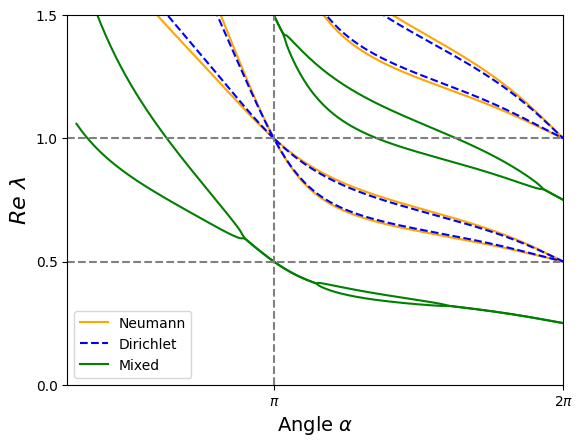

In [15]:
import numpy as np

# Define matrices
A_11 = np.array([[5, 0.6], [0.6, 1.5]])
A_12 = np.array([[0.25, -0.4], [-0.4, -0.2]])
A_22 = np.array([[1, 0], [0, 1]])

# Get S and D from V = S@D + 1j*D
V = getV(A_11, A_12)
D = np.imag(V)
S = np.real(V) @ inv(D)

alphas = np.linspace(1, 2 * np.pi - 0.001, 200)  # Use np.pi for clarity

# Prepare results lists for each type of boundary condition
results_d = []
results_m = []
results_n = []

# Define initial guesses for each boundary condition
initial_guesses_d = [0.5 + 0.1j, 1 + 0.1j]
initial_guesses_m = [0.25 + 0.1j, 0.75 + 0.1j]
initial_guesses_n = [0.5 + 0.1j, 1 + 0.1j]

# Loop for Dirichlet boundary conditions
for guess in initial_guesses_d:
    # Append results for perturbation in positive and negative directions
    results_d.append(newton_series(S,D, alphas, det_dirichlet, guess=guess, pert=0.05, cap=2, tol=1e-4))
    results_d.append(newton_series(S,D, alphas, det_dirichlet, guess=guess, pert=-0.05, cap=2, tol=1e-4))

# Loop for Mixed boundary conditions
for guess in initial_guesses_m:
    # Append results for perturbation in positive and negative directions
    results_m.append(newton_series(S,D, alphas, det_mixed, guess=guess, pert=0.05, cap=2, tol=1e-4))
    results_m.append(newton_series(S,D, alphas, det_mixed, guess=guess, pert=-0.05, cap=2, tol=1e-4))

# Loop for Neumann boundary conditions
for guess in initial_guesses_n:
    # Append results for perturbation in positive and negative directions
    results_n.append(newton_series(S,D, alphas, det_neumann, guess=guess, pert=0.05, cap=2, tol=1e-4))
    results_n.append(newton_series(S,D, alphas, det_neumann, guess=guess, pert=-0.05, cap=2, tol=1e-4))

# Extract real parts of results for plotting
real_results_d = [x.real for x in results_d]
real_results_m = [x.real for x in results_m]
real_results_n = [x.real for x in results_n]

# Plot the results using a custom plotting function
plot_lambdas_alphas(
    alphas,
    results_d=real_results_d,
    results_m=real_results_m,
    results_n=real_results_n
)


### 4.5 Neumann branches for not formal positive tuple
We plot the branches of a tuple that is contractive Neumann well-posed but not formal positive. See Appendix B.

#### 4.5.1 Check conditions
First we define the tuple and check that it is contractive Neumann well-posed but not formal positive.

In [27]:
import numpy as np
from scipy.linalg import eigvals, inv

def check_contractive_neumann(V):
    """
    Check if a matrix V satisfies the contractive Neumann well-posedness condition.
    """
    C = V.real
    D = V.imag
    
    # Compute the spectral radius
    spectral_radius = max(abs(eigvals(inv(D) @ C - C @ inv(D))))
    
    if spectral_radius < 2:
        print("V is contractive Neumann well-posed.")
        return
    else:
        print("V is not contractive Neumann well-posed.")
        return

def is_positive_definite(matrix):
    """
    Check if a matrix is positive definite by verifying all eigenvalues are positive.
    """
    eigenvalues = eigvals(matrix)
    return np.all(eigenvalues > 0)

def check_formal_positive(V):
    """
    Check if a matrix V satisfies the formal positivity condition by constructing
    and checking a block matrix for positive definiteness.
    """
    # Define submatrices for the block matrix
    A_11 = np.conj(V).T @ V
    A_12 = -0.5 * (np.conj(V).T + V)
    A_22 = np.eye(A_11.shape[0])
    
    # Construct the block matrix
    A = np.block([[A_11, A_12],
                  [A_12, A_22]])
    
    # Check positive definiteness
    if is_positive_definite(A):
        print("V is formally positive.")
        return
    else:
        print("V is not formally positive.")
        return

# Example Usage
D = np.array([[2, 1], [1, 2]])
S = np.array([[0, 0], [0, 2]])

# Define V
V = (S + 1j * np.eye(2)) @ D

# Check both properties
check_contractive_neumann(V)
check_formal_positive(V)


V is contractive Neumann well-posed.
V is not formally positive.


#### 4.5.2 Plot the branches

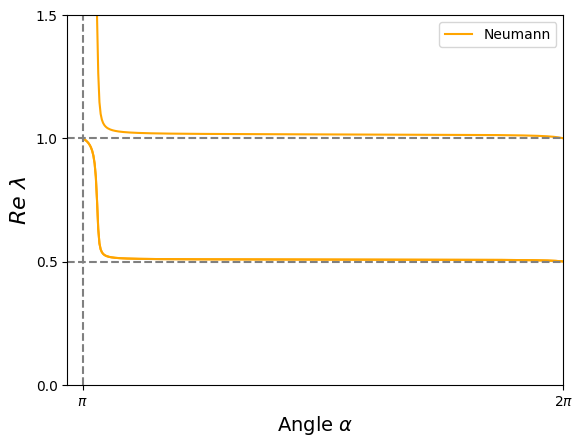

In [30]:
alphas = np.linspace(pi, 2 * pi - 0.001, 400)

results_n=[]

initial_guesses_n=[0.5 + 0.1j,1+0.1j]

results_n.append(newton_series(S,D,alphas,det_neumann,guess=0.5+0.1j,pert=-0.03,cap=2,tol=1e-6))
results_n.append(newton_series(S,D,alphas,det_neumann,guess=0.5-0.1j,pert=+0.02+0.01j,cap=2,tol=1e-6))
results_n.append(newton_series(S,D,alphas,det_neumann,guess=1,pert=-0.02-0.01j,cap=2,tol=1e-6))

plot_lambdas_alphas(alphas,results_n=[x.real for x in results_n])

### 4.6 Optimality of the bounds
We plot Dirichlet, Mixed, and Neumann boundary conditions for a scalar tuple which is close to the bounds given in the main results found in Section 7. See also Section 8.4.

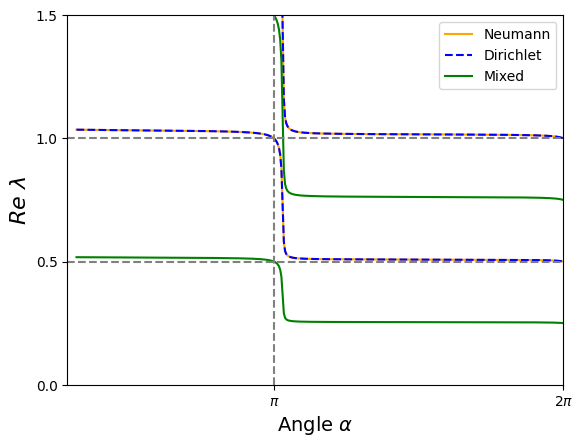

In [31]:
D=np.array([[1]])
S=np.array([[-10]])

alphas = np.linspace(1, 2 * pi - 0.001, 400)

results_d=[]
results_m=[]
results_n=[]

initial_guesses_d=[0.5+0.1j,1+0.1j]
initial_guesses_m=[0.25 + 0.1j,0.75+0.1j]
initial_guesses_n=[0.5 + 0.1j,1+0.1j]

for guess in initial_guesses_d:
    results_d.append(newton_series(S,D,alphas,det_dirichlet,guess=guess,pert=0.05,cap=2,tol=1e-4))

for guess in initial_guesses_m:
    results_m.append(newton_series(S,D,alphas,det_mixed,guess=guess,pert=0.05,cap=2,tol=1e-4))

for guess in initial_guesses_n:
    results_n.append(newton_series(S,D,alphas,det_neumann,guess=guess,pert=0.05,cap=2,tol=1e-4))

plot_lambdas_alphas(alphas,results_d=[x.real for x in results_d],results_m=[x.real for x in results_m],results_n=[x.real for x in results_n])